In [1]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import random

import sklearn as sk

# Preparation

## Load Data

In [2]:
# read chord data

data_chords = pd.read_csv('chord_list.tsv', sep='\t')

data_chords

,id,chord_id,mc,mn,onset,chords,chord,key,pedal,numeral,...,relativeroot,phraseend,globalkey,bass_step,mc_next,onset_next,next_chord_id,chord_length,globalminor,localminor
0,0,0,0,1,0,.A.I,I,I,NaN,I,...,NaN,NaN,A,1,0,3/8,1.0,3/8,False,False
1,0,1,0,1,3/8,V7,V7,I,NaN,V,...,NaN,NaN,A,5,0,3/4,2.0,3/8,False,False
2,0,2,0,1,3/4,I,I,I,NaN,I,...,NaN,NaN,A,1,0,9/8,3.0,3/8,False,False
3,0,3,0,1,9/8,V7,V7,I,NaN,V,...,NaN,NaN,A,5,1,0,4.0,3/8,False,False
4,0,4,1,2,0,I,I,I,NaN,I,...,NaN,NaN,A,1,1,3/8,5.0,3/8,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142506,696,160058,280,281,1/2,I,I,I,NaN,I,...,NaN,NaN,f,1,280,3/4,160059.0,1/4,True,False
142507,696,160059,280,281,3/4,I6,I6,I,NaN,I,...,NaN,NaN,f,3,281,0,160060.0,1/4,True,False
142508,696,160060,281,282,0,V(64),V(64),I,NaN,V,...,NaN,NaN,f,5,281,1/2,160061.0,1/2,True,False
142509,696,160061,281,282,1/2,V7,V7,I,NaN,V,...,NaN,NaN,f,5,282,0,160062.0,1/2,True,False


In [3]:
sequences_chords = [np.array(piece["chord"]) for name, piece in data_chords.groupby("id")]
sequences_chords[0]

array(['I', 'V7', 'I', 'V7', 'I', 'V', 'I', 'I6', 'I', 'V(64)', 'IV',
       'I6', 'IV', 'V', 'V64', 'I', 'V6', 'V6(6)', 'V', 'I', 'V(64)',
       'IV', 'I6', 'V65/IV', 'V6(6)/IV', 'V/IV', 'IV', 'IV6', 'V64/IV',
       'viio/V', 'V6/V', 'V7/V', 'V', 'V64', 'IV/V', 'V6', 'ii65/V',
       'V/V', 'V6/V', 'V7/V', 'V(9)', 'V6', 'IVM7/V', 'V(4)/V', 'ii65/V',
       'V/V', 'V', 'ii7/V', 'V6', 'IV/V', 'V', 'IV6/V', 'V', 'ii6/V', 'V',
       'IV6/V', 'V(64)/V', 'ii65/V', 'V6', 'IV/V', 'V6', 'V7', 'IV6',
       'V65', 'I', 'V7/IV', 'IV6/IV', 'V65/IV', 'IV(9)', 'V', 'viio',
       'V65/vi', 'vi', 'viio64', 'V7/vi', 'IV', 'V65/V', 'V7', 'V65/vi',
       'vi', 'ii%65/vi', 'V(4)/vi', 'V(+4)/vi', 'vi', 'ii%7/vi', 'V/ii',
       'ii', 'V7/ii', 'ii6', '#viio6/ii', 'iio/vi', 'V7/ii', 'ii', 'V/ii',
       'ii%7/vi', 'V/ii', '#viio64/ii', 'ii6', '#viio6/ii', 'ii', 'ii6',
       'VI/ii', 'iv/ii', 'ii', 'V/ii', 'V6/ii', 'ii', 'V65/ii', 'V64/ii',
       'ii6', 'V65/V', 'iv/ii', 'iv6/ii', 'V(64)/ii', 'ii%65/i

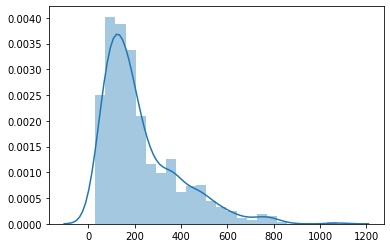

In [4]:
sns.distplot([len(s) for s in sequences_chords])

## Code for Computing Mutual Information Statistics

See "Critical Behaviour in Physics and Probabilistic Formal Languages" (Lin & Tenmark, 2017), Appendix D,
and "Parallels in the sequential organization of birdsong and human speech" (Sainburg et al., 2019).

In [5]:
# estimate the entropy of a distribution from samples
# expects a list or numpy array of samples
def est_entropy(samples):
    N = len(samples)
    counter = Counter(samples)
    counts = np.fromiter(Counter(samples).values(), dtype=int)
    return np.log2(N) - (sum(counts * scipy.special.psi(counts)) / N)
    #return np.log2(N) - ((sum([counts * scipy.special.psi(counts) for (key, counts) in counter.items()])) / N)

# estimate the mutual information between two variable from sample pairs
# expects an array with two columns
def est_mi(pairs):
    X = pairs[:,0]
    Y = pairs[:,1]
    pairs_tup = list(map(tuple,pairs))
    sX = est_entropy(X)
    sY = est_entropy(Y)
    sP = est_entropy(pairs_tup)
    return sX + sY - sP

def est_mi_corr(pairs, shuffled_pairs):
    return est_mi(pairs) - est_mi(shuffled_pairs)

In [6]:
def seq_pairs(sequence, distance):
    return np.column_stack([sequence[:-distance], sequence[distance:]])

def seqs_pairs(sequences, distance):
    #print(distance)
    return np.concatenate([seq_pairs(seq, distance) for seq in sequences])

In [7]:
def show_progress(dist):
    print(dist)
    return dist

def collect_mi(seqs, maxdist=100):
    maxdist = min(maxdist+1, max(map(len, seqs)))
    shuffled = [np.random.permutation(s) for s in seqs]
    values = [(show_progress(dist), est_mi_corr(seqs_pairs(seqs, dist), seqs_pairs(shuffled, dist))) for dist in range(1,maxdist)]
    return pd.DataFrame.from_records(values, columns=["dist", "mi"])

# Exercise 1: Plot Mutual Information

In this exercise we want to look at some information theoretic properties of the chord sequences we loaded above.
The [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between two random variables $A$ and $B$ measures how much we learn about $B$ by observing $A$ and vice versa.
In a chord sequence, for example, we can ask how much knowing the first chord tells us about the third cord.
In this case we want to look at pairs of chords with a certain distance, e.g., how much do we learn from a chord about the chord that comes 2, 3, or 4 steps later.
With increasing distance, this mutual information is probably going to decrease, but we want to look at how exactly this decay looks like.

Compute the mutual information for all chord distances and plot them.
Use the function `collect_mi`, which takes a list and an optional maximum distance, and returns a dataframe with the mutual information depending on the distance.

In [8]:
mi_chords = collect_mi(sequences_chords)
mi_chords

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


,dist,mi
0,1,0.932609
1,2,0.581949
2,3,0.369422
3,4,0.366222
4,5,0.260052
...,...,...
95,96,0.004137
96,97,0.000888
97,98,0.001736
98,99,0.005971


[None, None]

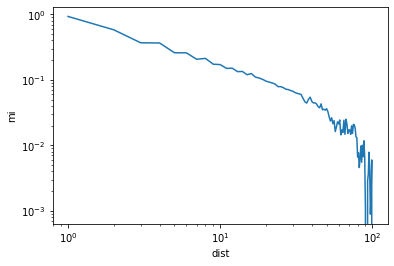

In [9]:
plot = sns.lineplot(data=mi_chords, x="dist", y="mi")
plot.set(xscale="log", yscale="log")

# Exercise 2: Markov Model

We now want to see, how well a markov model can model the structure of the chord sequences.
For this exercise you can reuse your solution from two weeks ago.

1. Use the chord sequences to train a 1st-order markov model.
1. Use the model to generate new sequences of length 200.
1. Compute and plot the mutual information statistics on these sequences. What do you observe?

In [10]:
# Compute bigrams

bigrams = map(tuple, seqs_pairs(sequences_chords, 1))
counts = Counter(bigrams)
counts.most_common(20)

[(('V7', 'I'), 2997),
 (('V', 'I'), 2246),
 (('V', 'i'), 1694),
 (('V(64)', 'V7'), 1326),
 (('I', 'I6'), 1198),
 (('V7', 'i'), 1175),
 (('I', 'V'), 1099),
 (('V65', 'I'), 1054),
 (('V2', 'I6'), 1052),
 (('I', 'V7'), 1010),
 (('V(4)', 'V'), 925),
 (('i', 'V'), 894),
 (('V(64)', 'V'), 873),
 (('I', 'IV'), 861),
 (('I6', 'I'), 748),
 (('I', 'I'), 721),
 (('V', 'V7'), 720),
 (('I6', 'IV'), 717),
 (('I', 'V43'), 645),
 (('V43', 'I'), 629)]

In [11]:
# Compute transition table

transitions = dict()
for ((x1, x2), count) in counts.items():
    if not (x1 in transitions):
        transitions[x1] = dict()
    transitions[x1][x2] = count

In [12]:
def normalize_dict(dictionary):
    S = sum(dictionary.values())
    return dict([(k, v/S) for (k, v) in dictionary.items()])

In [13]:
transitions_norm = dict([(x1, normalize_dict(counts)) for (x1, counts) in transitions.items()])

In [14]:
def next_note(trans, note):
    dist = trans[note]
    items = dist.items()
    candidates = [note for (note, prob) in items]
    probs = [prob for (note, prob) in items]
    return np.random.choice(candidates, p=probs)

In [15]:
def sample_piece(trans, length):
    note = np.random.choice(list(trans.keys()))
    notes = [note]
    for i in range(1, length):
        note = next_note(trans, note)
        notes.append(note)
    return notes

In [16]:
generated = [sample_piece(transitions_norm, 200) for i in range(0,500)]

In [17]:
generated[0]

['bII(7)',
 'bII(6)',
 'bII',
 'V43/bII',
 'bII',
 'i',
 'V65/iv',
 'iv(4)',
 'IV64(4)/iv',
 'iio6',
 'V7',
 'I',
 'ii%65',
 'ii%43',
 'V',
 'i',
 'iv7',
 'V',
 'I',
 'V43',
 'V2',
 'I6',
 'IV',
 '#viio7/vi',
 'vi',
 'IV6',
 'V7',
 'VI',
 'V(4)',
 'V',
 'i',
 '#viio43/ii',
 'V2/ii',
 'ii6',
 'ii6(9+4)',
 'ii6',
 'V43/ii',
 'ii',
 'V7',
 'V(64)',
 'V(4)',
 'V7',
 'I',
 'viio/V',
 'V',
 'V',
 'V/IV',
 'IV',
 'ii',
 'V43',
 'i6',
 'V43',
 'viio64',
 'I(4)',
 'I',
 '#viio7/V',
 'V',
 'vi',
 'V6/v',
 'V/v',
 'v',
 'v7',
 'iio/v',
 'v6',
 'V7(4)/v',
 'V7/v',
 '#viio64/v',
 'V2/v',
 'v6',
 'V(4)/v',
 'V/v',
 'v',
 'V43',
 'I',
 'ii7',
 'V65/IV',
 'IV',
 'I',
 'ii2(2)',
 'ii6',
 'V',
 'i',
 'V',
 'V7',
 'V7(6)',
 'V7',
 'V',
 'i6',
 'i',
 'iv',
 'i6',
 'iv',
 'V7/iv',
 'V9/iv',
 'V/iv',
 'V(64)/iv',
 'V/iv',
 'iv6',
 'iio6',
 'I',
 'vii%7',
 'vi6',
 'V65',
 'I',
 'I6',
 'V2',
 'I6',
 'IV',
 'vii%7/V',
 'V(64)',
 'V',
 'I',
 'I',
 'V43',
 'I',
 'V(4)',
 'V2(64)',
 'V65',
 'I6',
 'V65/IV',
 'V6(

In [18]:
mi_generated = collect_mi(generated)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


[None, None]

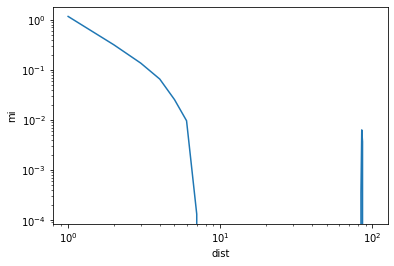

In [19]:
plot = sns.lineplot(data=mi_generated, x="dist", y="mi")
plot.set(xscale="log", yscale="log")

# Exercise 3 (optional): Modelling the Decay of Mutual Information

In the last exercise we saw how the decay of information changes when reconstructing the sequences from a markov model. In this exercise we want to see if the change is caused by the model not being "big" enough (a higher-order model might perform better, after all), or if the model class is not correct in the first place.

In a Markov model we expect an exponential decay of mutual information with increasing distance.
The intuitive reason for that is that if we go more than one step, we multiply the transition probabilities.
For $x$ steps, we therefore take the probability to the $x$th power.
The same is true for a markov model of higher order, except that the curve is less steep.
We can therefore model the decay as $MI(x) = a e^{xb} + c$, where $x$ is the distance.

Another decay function is a power law, where the distance is not in the exponent but is instead taken to a fixed negative power: $MI(x) = a x^b + c$.
This function decays asymtotically slower than the exponential and cannot be generated by a Markov model.

Try to fit both functions to the mutual information you observed in the original sequences. You can use the function [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) together with these function definitions:

In [20]:
exponential = lambda x, a, b, c: a * (np.e ** (-x*b)) + c
powerlaw = lambda x, a, b, c: a * (x ** b) + c

You will get a list of estimates for the parameters `a`, `b`, and `c` in each case.
Use these to

1. compute the estimated MI values for each distance,
1. compute the sum of squared errors between the estimates and the actual data, and
1. plot observed data together with the two fitted curves.

Which model explains the observed data better?

In [21]:
def fit_models(data):
    out = pd.DataFrame(data)
    popt_exp, pcov_exp = scipy.optimize.curve_fit(exponential, data["dist"], data["mi"])
    out["exp"] = exponential(data["dist"], popt_exp[0], popt_exp[1], popt_exp[2])
    loss_exp = sum((out["mi"] - out["exp"]) ** 2)

    popt_pow, pcov_pow = scipy.optimize.curve_fit(powerlaw, data["dist"], data["mi"], p0=[1.0,-2.0,0.0])
    out["pow"] = powerlaw(data["dist"], popt_pow[0], popt_pow[1], popt_pow[2])
    loss_pow = sum((out["mi"] - out["pow"]) ** 2)
    
    return out, loss_exp, loss_pow

In [22]:
out_chords, le_chords, lp_chords = fit_models(mi_chords)
print("loss exp:", le_chords)
print("loss pow:", lp_chords)

loss exp: 0.13236253445648682
loss pow: 0.007511264799424557


[None, None]

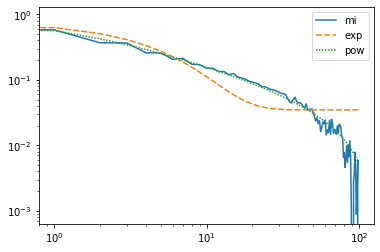

In [23]:
plot = sns.lineplot(data=out_chords[["mi", "exp", "pow"]])
plot.set(xscale="log", yscale="log")

In [24]:
out_gen, le_gen, lp_gen = fit_models(mi_generated)
print("loss exp:", le_gen)
print("loss pow:", lp_gen)

loss exp: 0.013943449754672805
loss pow: 0.009933058256053003


[None, None]

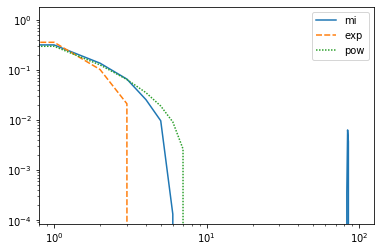

In [25]:
plot = sns.lineplot(data=out_gen[["mi", "exp", "pow"]])
plot.set(xscale="log", yscale="log")